## Detect ships in Planet data
This notebook demonstrates how to detect and count objects in satellite imagery using algorithms from Python's scikit-image library. In this example, we'll look for ships in a small area in the San Francisco Bay and generate a PNG of each ship with an outline around it.

### Input Parameters
This is a sample image that was generated using the Clip and Ship API. To test this with your own image, replace the parameters below.

In [1]:
sample_data_file_name = 'data/1056417_2017-03-08_RE3_3A_Visual_clip.tif'


### Original image
Below is a predefined image that has been clipped from the Planet API using [Clip and Ship](https://www.planet.com/docs/reference/clips-api/). This is the image that we are going to detect ships in.

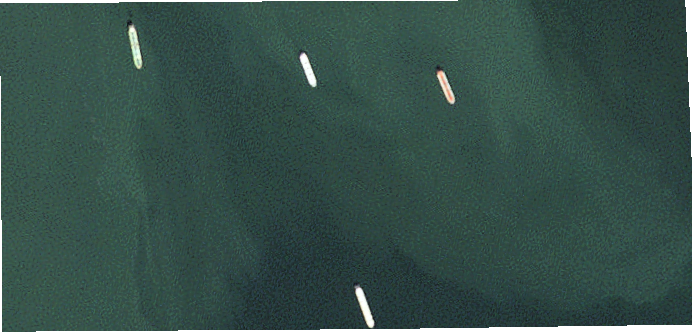

In [2]:
import skimage.io
from IPython.display import Image

# Read image into scimage package
img = skimage.io.imread(sample_data_file_name)
skimage.io.imsave('output/original.png', img)

# Display original image
display(Image(filename='output/original.png'))


### Run the ship detection algorithm 

{
  "ship_count": 4, 
  "ships": [
    {
      "lat": 557725.0, 
      "lng": 4176230.0, 
      "id": 1
    }, 
    {
      "lat": 558590.0, 
      "lng": 4176110.0, 
      "id": 2
    }, 
    {
      "lat": 559280.0, 
      "lng": 4176025.0, 
      "id": 3
    }, 
    {
      "lat": 558870.0, 
      "lng": 4174930.0, 
      "id": 4
    }
  ]
}


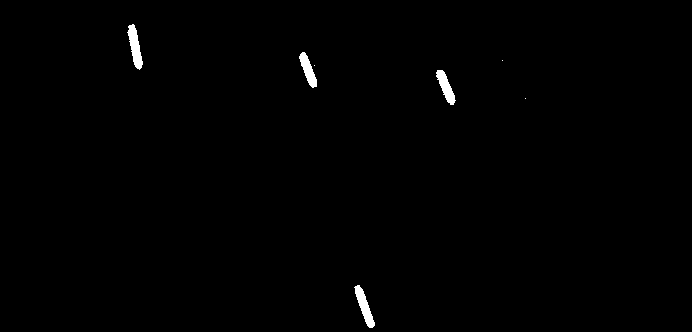

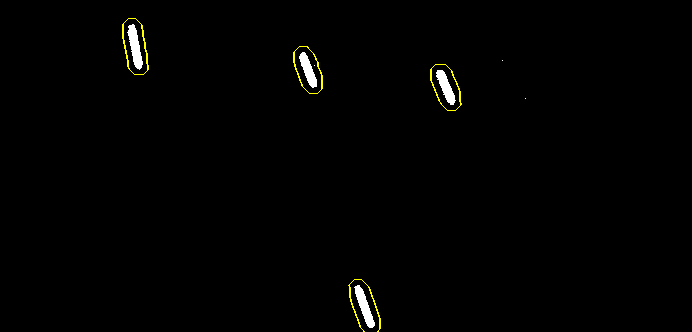

Ship 1


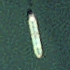

Ship 2


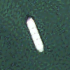

Ship 3


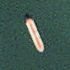

Ship 4


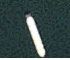

In [4]:
import json
from osgeo import gdal
import numpy
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.measure import regionprops

# Prepare result structure
result = {
    "ship_count": 0,
    "ships": []
}

# Open image with gdal
ds = gdal.Open(sample_data_file_name)
xoff, a, b, yoff, d, e = ds.GetGeoTransform()

# Convert multi-channel image it into red, green and blueb[, alpha] channels 
red, green, blue, alpha = numpy.rollaxis(numpy.array(img), axis=-1)

# Mask: threshold + stops canny detecting image boundary edges
mask = red > 75

# Create mask for edge detection
skimage.io.imsave('output/mask.png', mask * 255)

# Use Felzenszwalb algo to find segements
segments_fz = felzenszwalb(numpy.dstack((mask, mask, mask)),
                               scale=5000,
                               sigma=3.1,
                               min_size=25) 

# Build labeled mask to show where ships were dectected
segmented_img = mark_boundaries(mask, segments_fz)
skimage.io.imsave('output/mask_labeled.png', segmented_img)

# Count ships and save image of each boat clipped from masked image
for idx, ship in enumerate(regionprops(segments_fz)):
    
    # If area matches that of a stanard ship, count it
    if (ship.area >= 300 and ship.area <= 10000):
        
        # Incrment count
        result['ship_count'] += 1
        
        # Create ship thumbnail
        x, y = (int(numpy.average([ship.bbox[0],
                                ship.bbox[2]])),
                                int(numpy.average([ship.bbox[1],
                                ship.bbox[3]])))
        sx, ex = max(x - 35, 0), min(x + 35, img.shape[0] - 1)
        sy, ey = max(y - 35, 0), min(y + 35, img.shape[1] - 1)
        img_ship = img[sx:ex, sy:ey]
        skimage.io.imsave('output/ship-%s.png' % str(idx + 1), img_ship)

        # Get global coordinates from pixel x, y coords
        lat = a * y + b * x + xoff
        lng = d * y + e * x + yoff
        
        # Add ship to results cluster
        result["ships"].append({
            "id": idx + 1,
            "lat": lat,
            "lng": lng
        })

# Display results
print(json.dumps(result, indent=2))

#Display mask used for ship detection.
display(Image(filename='output/mask.png'))

# Display labled mask where we detected ships
display(Image(filename='output/mask_labeled.png'))

# Display each individual ship cropped out of the original image
for idx,ship in enumerate(result['ships']):
    print("Ship "+ str(idx + 1)) 
    display(Image(filename='output/ship-' + str(idx + 1) + '.png'))
